# Whiteout Detection


## First approach (based on colour)


In [ ]:
# first import packages
import cv2
import numpy as np
import imutils
import pytesseract
from pdf2image import convert_from_path

In [ ]:
#read image and determine the HSV boundries. 
frame = cv2.imread("page0.jpg") # image is shown below    
light_yelloy = np.array([22, 93, 0])
dark_yellow = np.array([45, 255, 255])

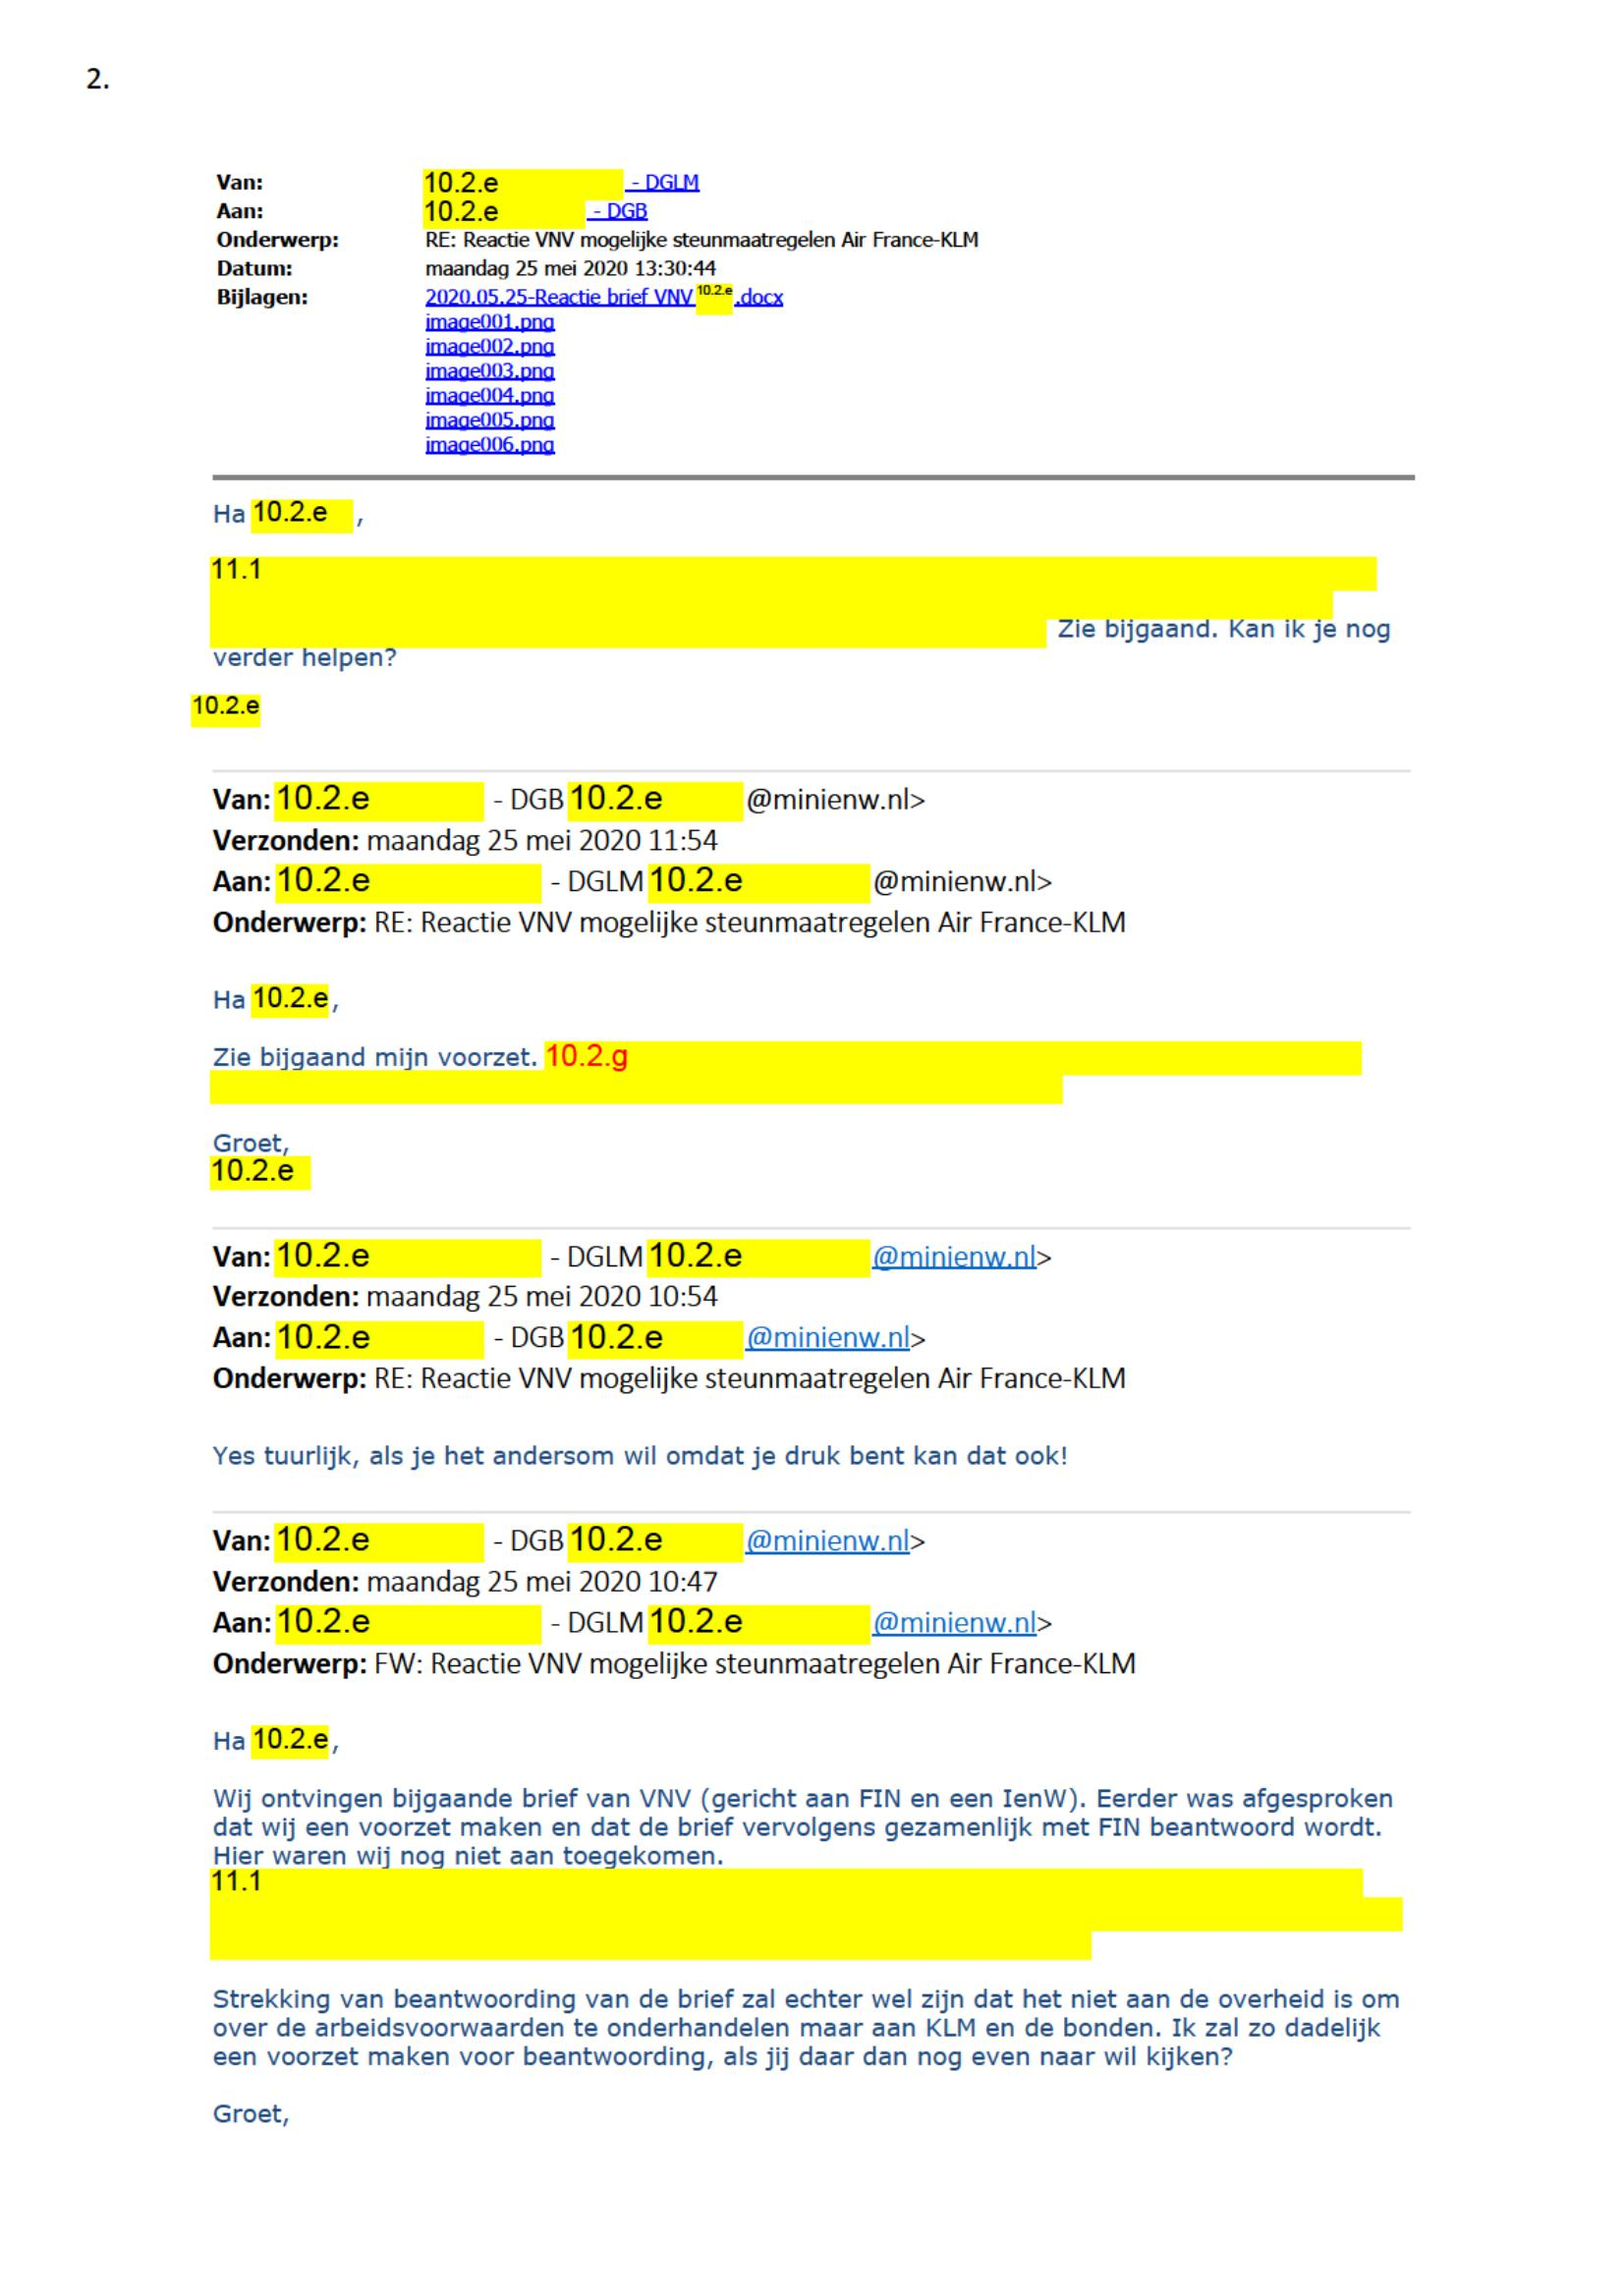

In [ ]:
# Convert BGR to HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# Threshold the HSV image to get only specified colors
mask = cv2.inRange(hsv, light_yelloy, dark_yellow)
#bitwise 
output = cv2.bitwise_and(frame,frame, mask= mask)
#show output 
cv2.imshow('output',output)
cv2.waitKey(0)

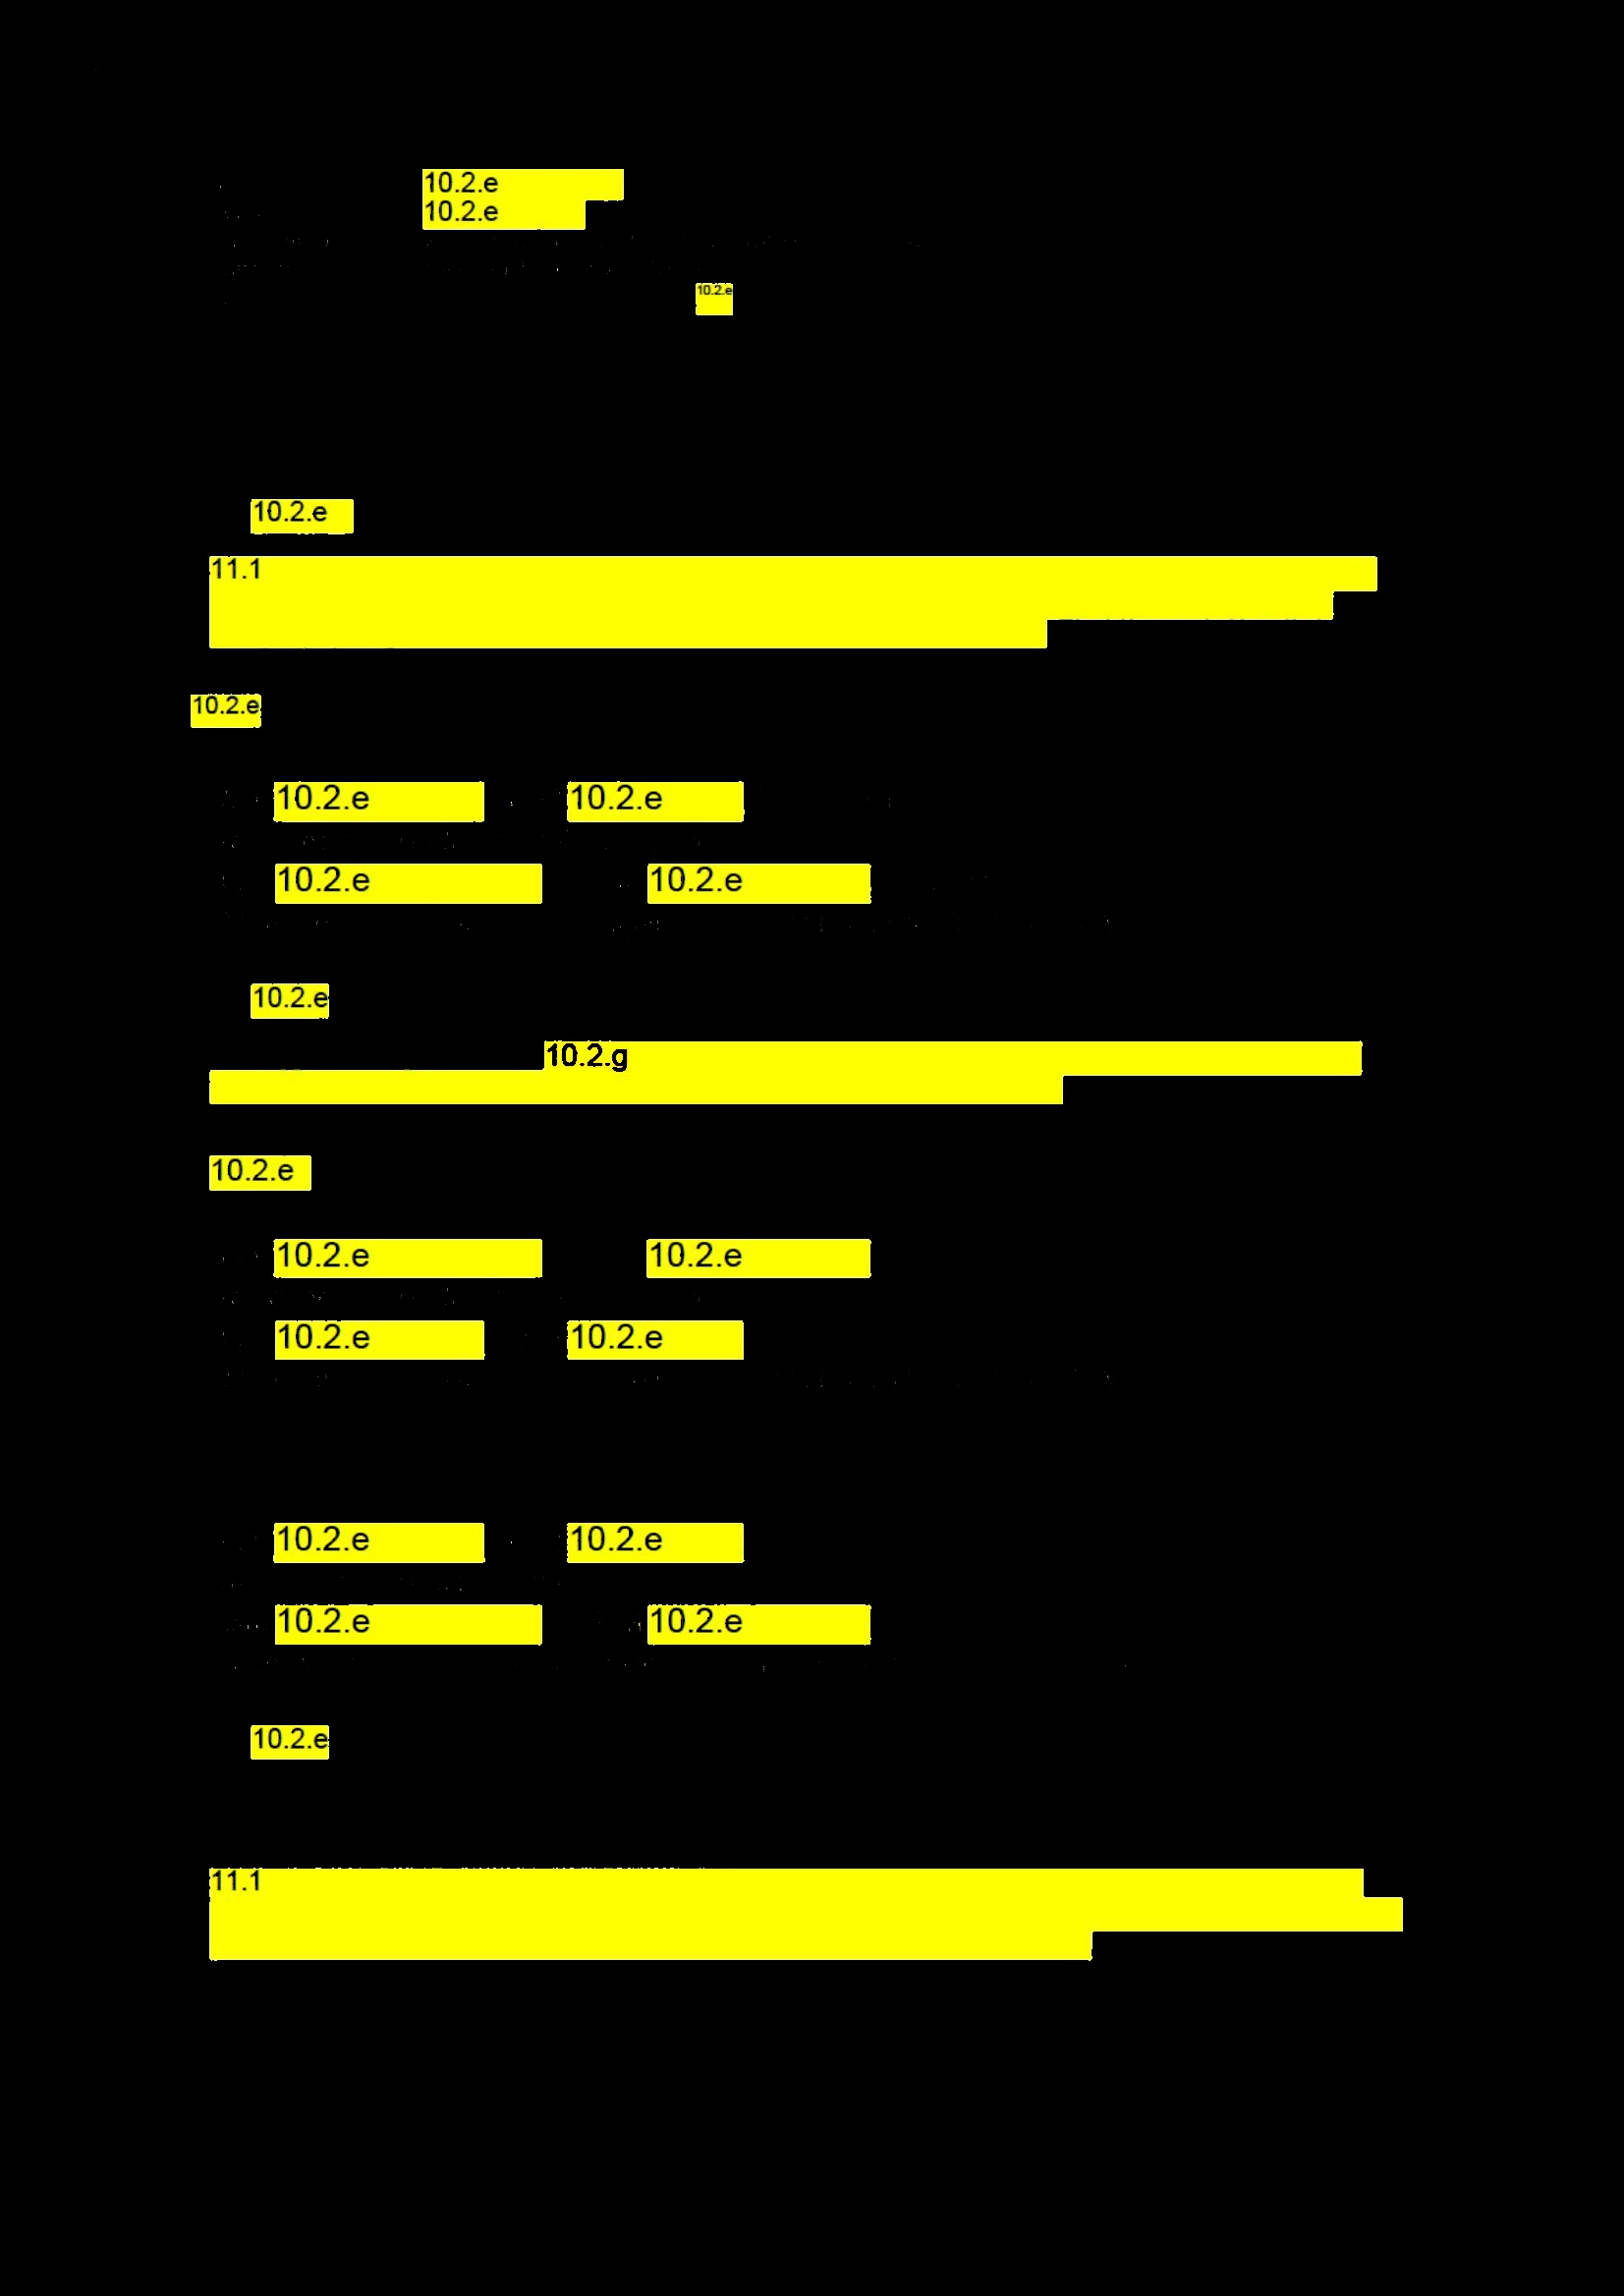

In the next steps, the output from above will be passed to the pytesseract to search for articles numbers 

In [ ]:
#create copy of output
outputCopy = output.copy()

# Filename
filename = 's.jpg'
  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, outputCopy)

#read newly created image 
frame1 = cv2.imread(filename)    

In [ ]:
# Convert the image to gray scale
gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
 
# Specify structure shape and kernel size.
# Kernel size increases or decreases the area
# of the rectangle to be detected.
# A smaller value like (10, 10) will detect
# each word instead of a sentence.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)

In [ ]:
# Creating a copy of image
im2 = frame1.copy()
 
# A text file is created and flushed
file = open("recognized.txt", "w+")
file.write("")
file.close()

In [ ]:
# Looping through the identified contours
# Then rectangular part is cropped and passed on
# to pytesseract for extracting text from it
# Extracted text is then written into the text file

# note, some of the text(10.2) does not get recognised  
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
     
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    # Cropping the text block for giving input to OCR
    cropped = im2[y:y + h, x:x + w]
     
    # Open the file in append mode
    file = open("recognized.txt", "a")
     
    # Apply OCR on the cropped image
    text = pytesseract.image_to_string(cropped)
    print ("ROI output",text)

    # Appending the text into file
    file.write(text)
    file.write("\n")
     
    # Close the file
    file.close

#### Output of the pytesseract:  
10.2.e

11.1

In [ ]:
#get coordinates 
X,Y = np.where(np.all(frame== light_yelloy, axis=2)) 
X1,Y1 = np.where(np.all(frame== dark_yellow, axis=2)) 

zippedLight = np.column_stack((X,Y))
zippedDark = np.column_stack((X1,Y1))

print("the coordinates are:.....")
print("light color:  ",zippedLight)
print("dark color:  ",zippedDark)

####  Coordinates of the colored regions

light color:   []
dark color:   [[ 301  718]
 [ 301  744]
 [ 918  662]
 [1026  307]
 [1202  235]
 [1373  755]
 [1579  588]
 [1657  344]
 [1658  700]]

### Risks & Issues

* Other documents did not use colours at all to whitewash information but shapes. 
* Not all colours are easily detected which is why the second approach is important (below)
* A lot of other documents DID NOT contain article numbers (such as 10.2 or 11.1). The pytesseract could not get all the article numbers in some documents (Could be solved by improving the preprocessing, thresholds & contour properties)  


## Second approach (based on shape)

In [ ]:
# Reading image
img2 = cv2.imread('page1.jpg', cv2.IMREAD_COLOR)

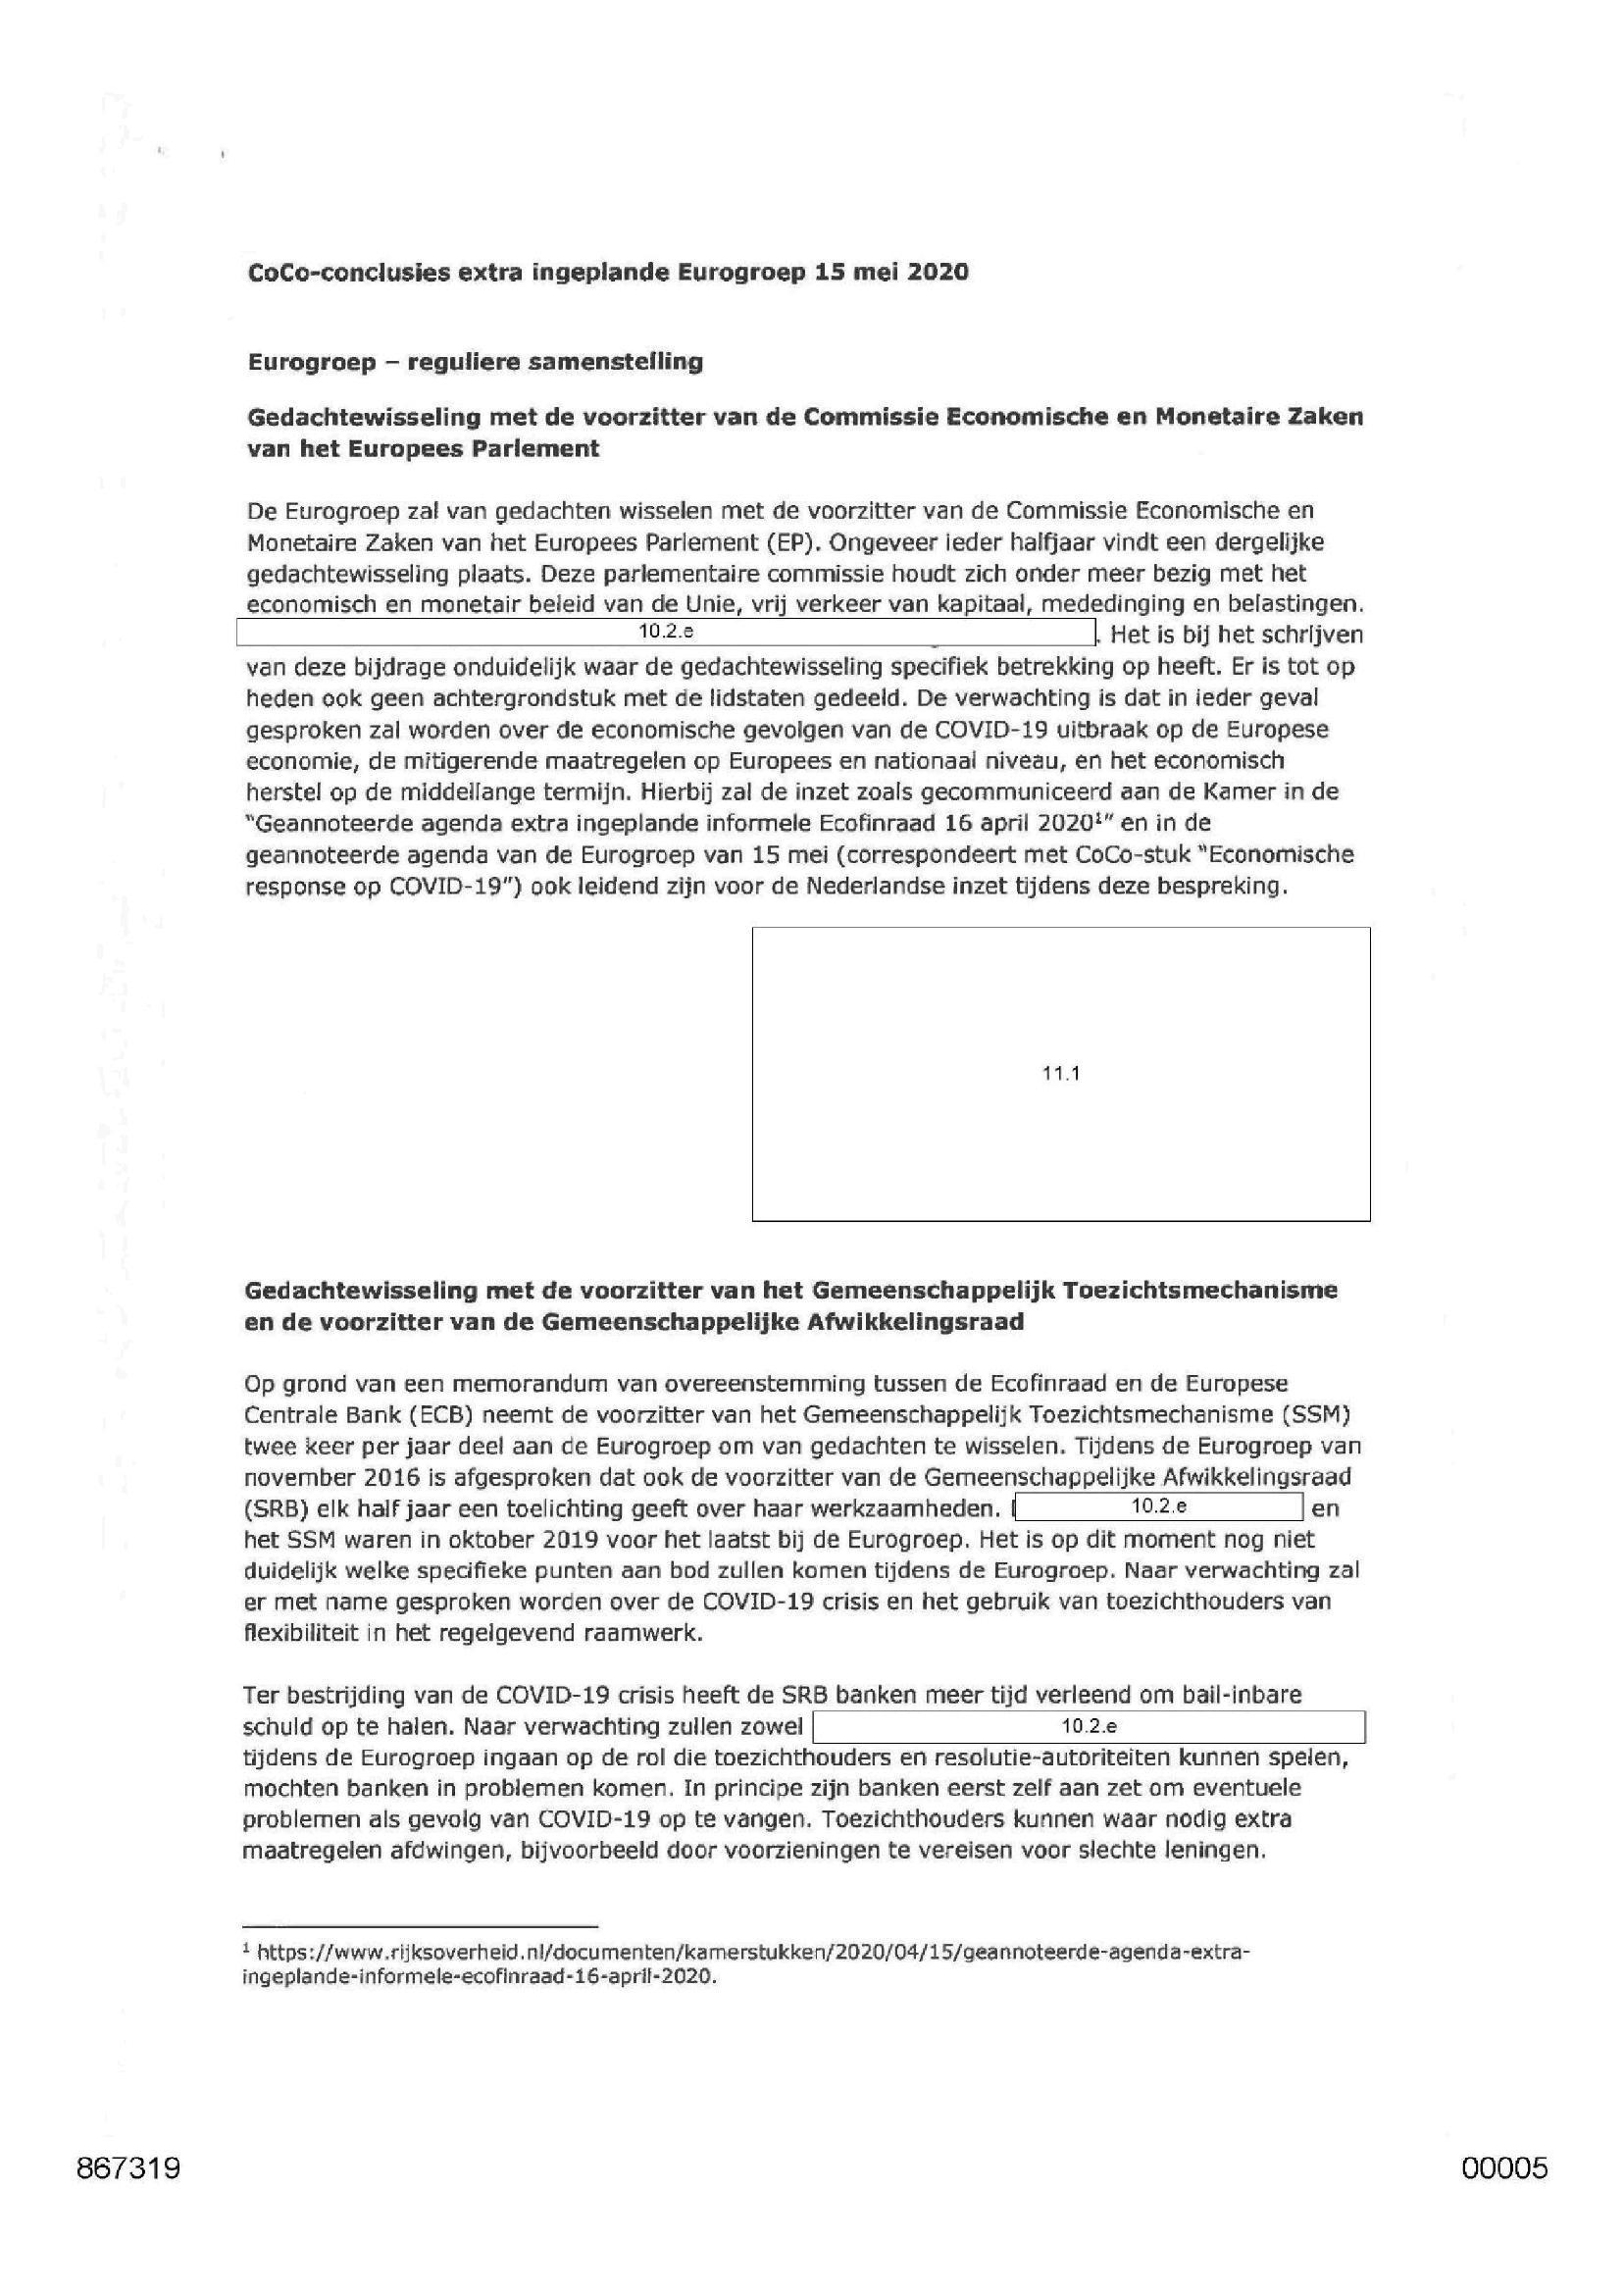

In [ ]:
#preprocessing
# Reading same image in another variable and 
# converting to gray scale.
img = cv2.imread('page1.jpg', cv2.IMREAD_GRAYSCALE)
   
# Converting image to a binary image 
# (black and white only image).
_,threshold = cv2.threshold(img, 220, 255, 
                            cv2.THRESH_BINARY)
   
# Detecting shapes in image by selecting region 
# with same colors or intensity.
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
# Searching through every region selected to 
# find the required polygon.
for cnt in contours :
    area = cv2.contourArea(cnt)
   
    # Shortlisting the regions based on there area.
    if area > 100: 
        approx = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
        if(len(approx) == 4) or len(approx) == 5 or len(approx) == 6 : 
            cv2.drawContours(img2, [approx], 0, (0, 0, 255), 5)
   

In [ ]:
# Showing the image along with outlined arrow.
cv2.imshow('image2', img2) 
# Exiting the window if 'q' is pressed on the keyboard.
if cv2.waitKey(0) & 0xFF == ord('q'): 
    cv2.destroyAllWindows()

Output below

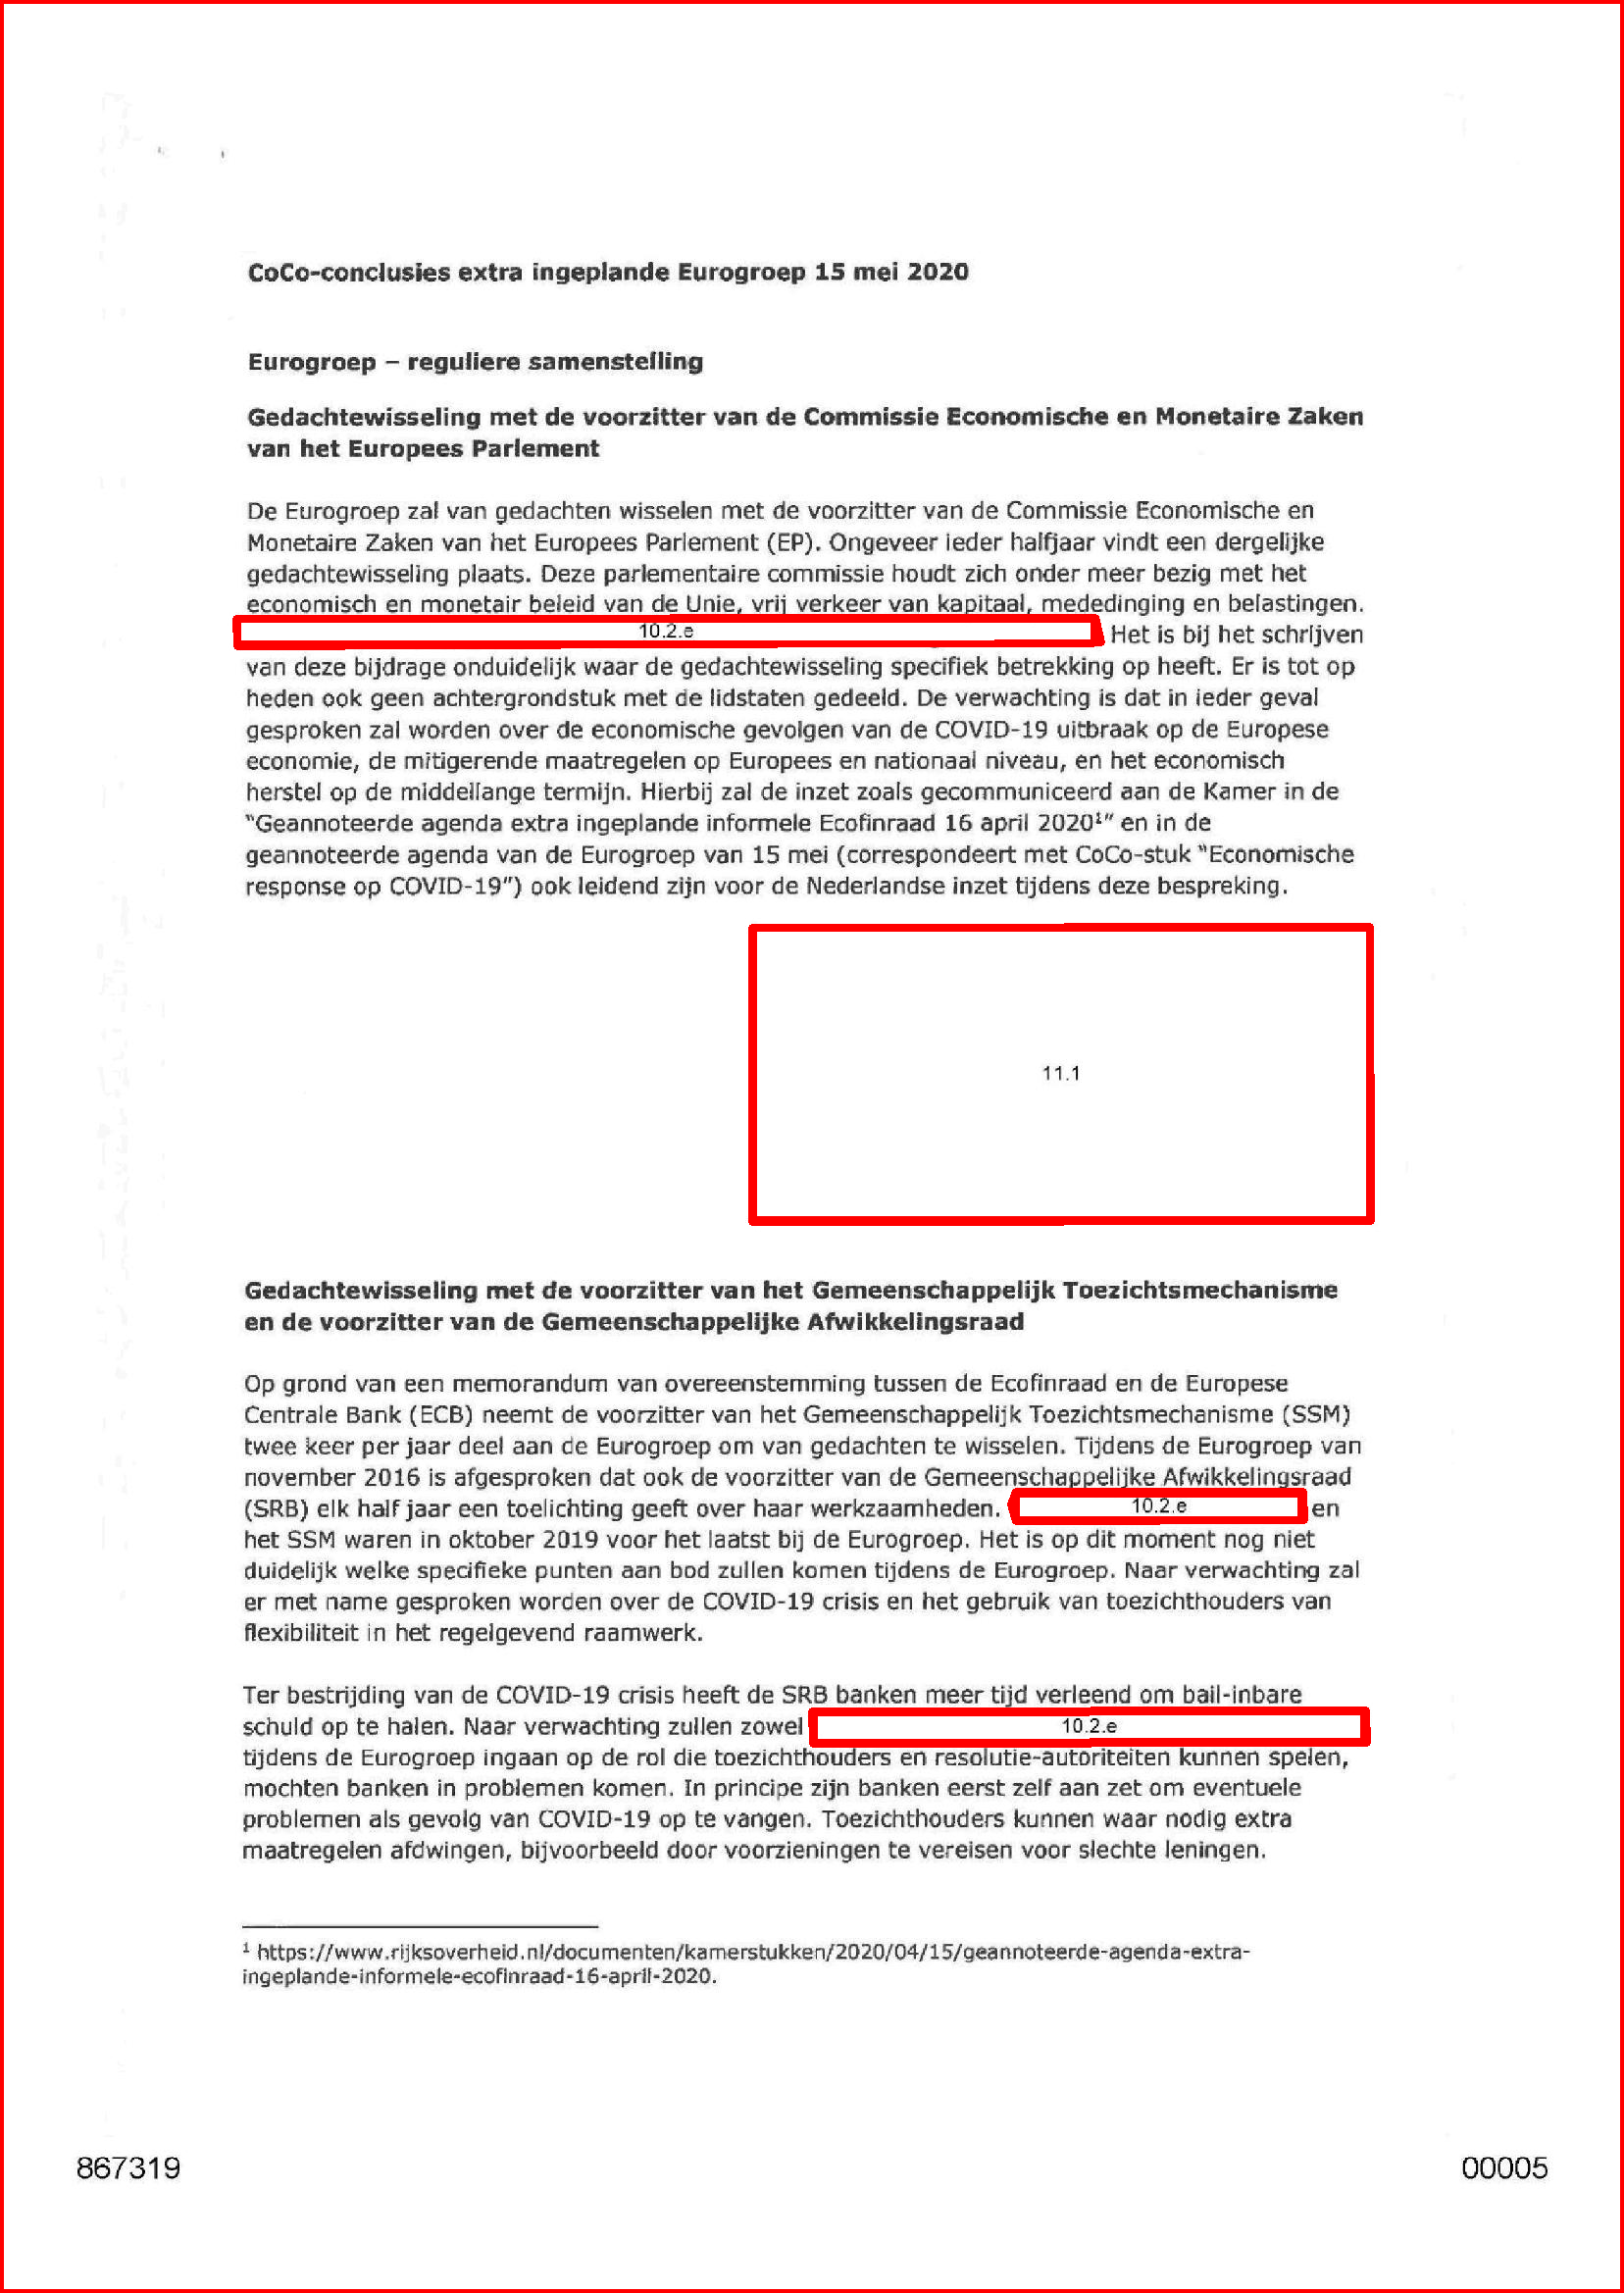

As shown below another image with a different type of whitewashing was tried and the whitewashed places were detected. The first approach could not get whitewashed regions  

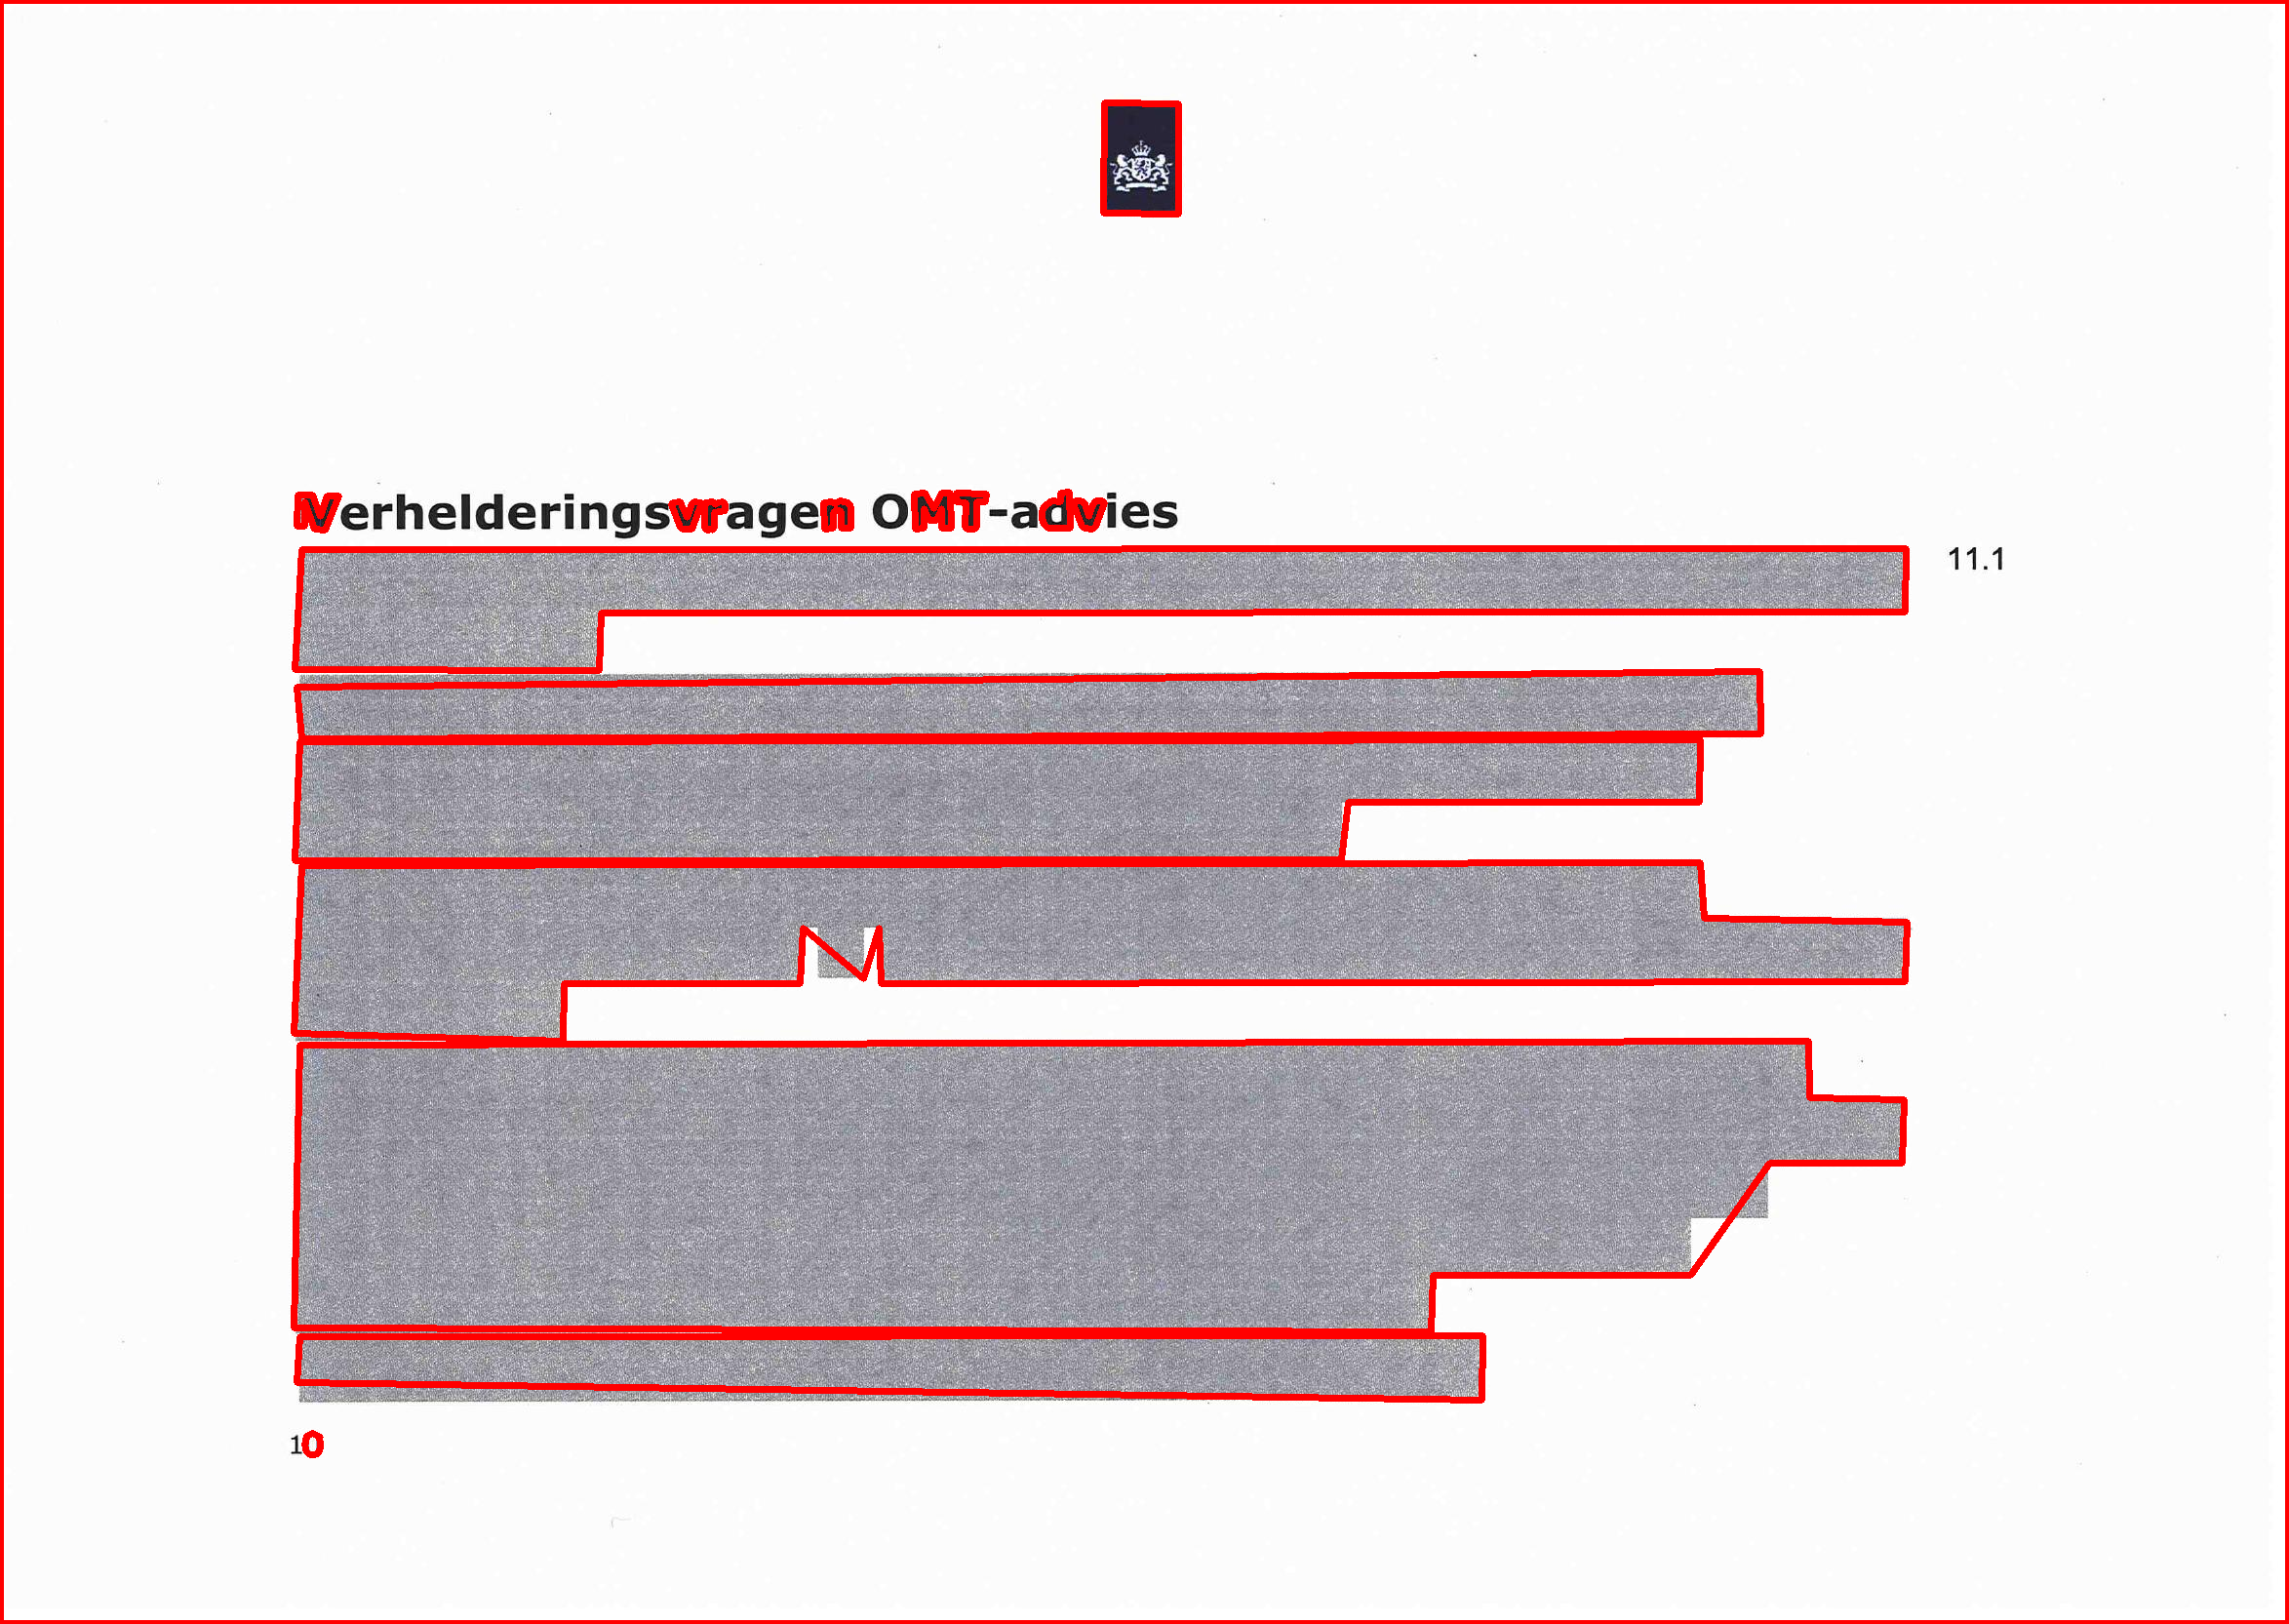

# Next steps (for today and next few days)

* Improve the approaches by experimenting with threshholds and contour features & properties. 
* Write a script to classify what kind of info was whitewashed (Personal info or Informative text) 
* Determine How to test (Bcubed P & R).
* Research what's used to whitewash sensitive information in terms of software tools and how the whitewashing is checked  